In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import argparse
import os
import torch
import torchvision
import numpy as np
from torch.backends import cudnn
from torch import optim
import torch.autograd as autograd
from torch.autograd import Variable
from torch.utils import data
from torchvision import transforms
from torchvision import datasets
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from math import log

In [16]:
parser = argparse.ArgumentParser(description='Easy Implementation of InfoGAN')

# model hyper-parameters
parser.add_argument('--image_size', type=int, default=128) # 32 for kpc32
parser.add_argument('--z_dim', type=int, default=2) #
parser.add_argument('--featu_dim', type=int, default=2) #

# training hyper-parameters
parser.add_argument('--num_epochs', type=int, default=5) # 30 or 50 for MNIST / 4 for CelebA
parser.add_argument('--test_epochs', type=int, default=1)
parser.add_argument('--batch_size', type=int, default=8)
parser.add_argument('--num_workers', type=int, default=2)
parser.add_argument('--lrD', type=float, default=0.0005) # Learning Rate for D
parser.add_argument('--lrG', type=float, default=0.0005) # Learning Rate for G
parser.add_argument('--beta1', type=float, default=0.5)  # momentum1 in Adam
parser.add_argument('--beta2', type=float, default=0.999)  # momentum2 in Adam

# InfoGAN parameters
parser.add_argument('--cc_dim', type=int, default=1)
parser.add_argument('--dc_dim', type=int, default=3)# class
parser.add_argument('--continuous_weight', type=float, default=1.0) # 0.1~0.5 for MNIST / 1.0 for CelebA

# misc
parser.add_argument('--db', type=str, default='kpc128')  # Model Tmp Save
parser.add_argument('--model_g_path', type=str, default='./models/models_g_128')  # Model Tmp Save
parser.add_argument('--model_d_path', type=str, default='./models/models_d_128')  # Model Tmp Save
parser.add_argument('--model_c_path', type=str, default='./models/models_c_128')  # Model Tmp Save
parser.add_argument('--sample_path', type=str, default='./results/result_128')  # Results
parser.add_argument('--sample_path_2', type=str, default='./results')  # Results
parser.add_argument('--sample_size', type=int, default=30) #5 class * 10列
parser.add_argument('--log_step', type=int, default=100)
parser.add_argument('--sample_step', type=int, default=100)
args = parser.parse_args("")  #remember this

In [3]:
class Generator(nn.Module):
    def __init__(self, db='kpc128', z_dim=32, cc_dim = 1, dc_dim=10):
        super(Generator, self).__init__()
        self.db = db
        
        self.fc = nn.Sequential(
            nn.Linear(cc_dim + dc_dim + z_dim, 8*16*16),
            nn.BatchNorm1d(8*16*16),
            nn.ReLU(),
        )
        self.conv = nn.Sequential(               
            nn.ConvTranspose2d(8,64,4,2,1),#[16 to 32]
            nn.ReLU(),
            
            nn.ConvTranspose2d(64,128,4,2,1),#[32 to 64]
            nn.ReLU(),

            nn.ConvTranspose2d(128,3,4,2,1),#[64 to 128]
            nn.Tanh()
        )
    def forward(self, z):
        z = self.fc( z )
        z = z.view(-1, 8, 16, 16)
        out = self.conv(z)
            
        return out

In [4]:
class Discriminator(nn.Module):
    def __init__(self, db='kpc128', featu_dim = args.featu_dim):
        super(Discriminator, self).__init__()
        self.db = db
        self.conv = nn.Sequential(
            nn.Conv2d(3, 128, 4, 2, 1), # [128 to 64]
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),

            nn.Conv2d(128, 64, 4, 2, 1), #[64 to 32]
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),
            
            nn.Conv2d(64, 32, 4, 2, 1), #[32 to 16]
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1, inplace=True),
            
            nn.Conv2d(32, 16, 4, 2, 1), #[16 to 8]
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.1, inplace=True),

        )
        self.fc = nn.Sequential(
            nn.Linear(16*8*8, featu_dim),
            #nn.ReLU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(featu_dim, 1),
        )
    def forward(self, x):
        tmp = self.conv(x)
        tmp = tmp.view(-1, 16*8*8)
        featu = self.fc(tmp)
        out = self.fc2(featu)
        
        # Discrimination Output
        out[:, 0] = F.sigmoid(out[:, 0].clone()) #take the first value as the class. sigmoid for binary classify: real(1) or fake(0)

        return out, featu

In [5]:
class Classifier(nn.Module): # net Q
    def __init__(self, db='kpc128', cc_dim = args.cc_dim, dc_dim = args.dc_dim):
        super(Classifier, self).__init__()
        self.db = db
        self.cc_dim = cc_dim
        self.dc_dim = dc_dim
        
        self.conv = nn.Sequential(
            nn.Conv2d(3, 128, 4, 2, 1), # [128 to 64]
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),

            nn.Conv2d(128, 64, 4, 2, 1), #[64 to 32]
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),
            
            nn.Conv2d(64, 32, 4, 2, 1), #[32 to 16]
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1, inplace=True),
            
            nn.Conv2d(32, 16, 4, 2, 1), #[16 to 8]
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.1, inplace=True),

        )
        self.fc = nn.Sequential(
            nn.Linear(16*8*8, cc_dim + dc_dim),
            nn.ReLU(),
        )
    def forward(self, x):
        tmp = self.conv(x)
        tmp = tmp.view(-1, 16*8*8)
        out = self.fc(tmp)
        
        #out[:, self.cc_dim:self.cc_dim+self.dc_dim] = F.softmax(out[:, self.cc_dim:self.cc_dim+self.dc_dim].clone())
        
        return out

In [17]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
transform = transforms.Compose([
    transforms.Scale((args.image_size, args.image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5,), (0.5, 0.5, 0.5, ))])

dataset=np.load("./kpc/data1/128.npy")
print(dataset.shape)
dataset = np.moveaxis(dataset, 3, 1)
print(dataset.shape)
data_loader = data.DataLoader(dataset=dataset,
                                batch_size=args.batch_size,
                                shuffle=True,
                                num_workers=args.num_workers)

(16827, 128, 128, 3)
(16827, 3, 128, 128)


In [18]:
# #load data--
# transform = transforms.Compose([
#     transforms.Scale((args.image_size, args.image_size)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5,), (0.5, 0.5, 0.5, ))])

# if args.db=='kpc128': # kpc64
#     #dataset = ImageFolder(args.image_path, transform)# modify the path
#     dataset = np.load("./kpc/data0/slice128_Block2_11K.npy")
#     print(dataset.shape)####################
#     dataset = dataset[:, 0, :, :, :]
#     dataset = np.moveaxis(dataset, 3, 1)
#     print(dataset.shape)
#     dataset.astype(float)
#     dataset = dataset/255
#     dataset = torch.from_numpy(dataset)
#     #dataset = dataset.to(device)
#     print(dataset.shape)
# #dataloader = torch.utils.DataLoader(dataset)
    
# data_loader = data.DataLoader(dataset=dataset,
#                                 batch_size=args.batch_size,
#                                 shuffle=True,
#                                 num_workers=args.num_workers)

In [19]:
def to_variable(x): # use GPU
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

# InfoGAN Function (Gaussian)
def gen_cc(n_size, dim):
    return torch.Tensor(np.random.randn(n_size, dim)*0.5)

# InfoGAN Function (Multi-Nomial)
def gen_dc(n_size, dim):
    codes=[]
    code = np.zeros((n_size, dim))
    random_cate = np.random.randint(0, dim, n_size)
    code[range(n_size), random_cate] = 1
    codes.append(code)
    codes = np.concatenate(codes,1)
    return torch.Tensor(codes)

LAMBDA = 1 # Gradient penalty lambda hyperparameter

In [20]:
# import torch
# import numpy as np
# import random
# #-------Fixed noise----
# mmm = int(args.sample_size / 10)
# print(mmm)

# empty = torch.full((1, args.z_dim), 1)
# ten_empty = torch.full((1,args.z_dim), 1)

# for x in range(mmm):
#     one_row = torch.rand(1,args.z_dim)

#     for i in range(10):
#         empty = torch.cat((empty, one_row), 0) 

# ten_empty = torch.cat((ten_empty, empty), 0)

# ten_empty = ten_empty[torch.arange(ten_empty.size(0))!=0]
# ten_empty = ten_empty[torch.arange(ten_empty.size(0))!=0]

# print(ten_empty.shape)

# #-----------------------------
# fixed_noise = to_variable(ten_empty)
# print(fixed_noise)
# print(fixed_noise.dtype)

In [77]:
#-------Fixed noise----
empty = torch.full((1, args.z_dim), 1)
one_row = torch.rand(1,args.z_dim)
for x in range(args.sample_size):
    empty = torch.cat((empty, one_row), 0)
empty = empty[torch.arange(empty.size(0))!=0]
#print(empty.shape, empty)
fixed_noise = to_variable(empty)
print(fixed_noise)
print(fixed_noise.shape)

tensor([[0.1323, 0.3396, 0.2601, 0.6886],
        [0.1323, 0.3396, 0.2601, 0.6886],
        [0.1323, 0.3396, 0.2601, 0.6886],
        [0.1323, 0.3396, 0.2601, 0.6886],
        [0.1323, 0.3396, 0.2601, 0.6886],
        [0.1323, 0.3396, 0.2601, 0.6886],
        [0.1323, 0.3396, 0.2601, 0.6886],
        [0.1323, 0.3396, 0.2601, 0.6886],
        [0.1323, 0.3396, 0.2601, 0.6886],
        [0.1323, 0.3396, 0.2601, 0.6886],
        [0.1323, 0.3396, 0.2601, 0.6886],
        [0.1323, 0.3396, 0.2601, 0.6886],
        [0.1323, 0.3396, 0.2601, 0.6886],
        [0.1323, 0.3396, 0.2601, 0.6886],
        [0.1323, 0.3396, 0.2601, 0.6886],
        [0.1323, 0.3396, 0.2601, 0.6886],
        [0.1323, 0.3396, 0.2601, 0.6886],
        [0.1323, 0.3396, 0.2601, 0.6886],
        [0.1323, 0.3396, 0.2601, 0.6886],
        [0.1323, 0.3396, 0.2601, 0.6886],
        [0.1323, 0.3396, 0.2601, 0.6886],
        [0.1323, 0.3396, 0.2601, 0.6886],
        [0.1323, 0.3396, 0.2601, 0.6886],
        [0.1323, 0.3396, 0.2601, 0

In [21]:
# === entropy compute === #
def get_binary_KLD(pp, qq, batch_mean=True):
    tmp = torch.sum( (pp*(torch.log(pp+1e-8)-torch.log(qq+1e-8)) + (1-pp)*(torch.log(1-pp+1e-8)-torch.log(1-qq+1e-8))), dim=1)
    if(batch_mean):
        return(torch.mean(tmp))
    else:
        return(tmp)

def get_binary_cross_entropy(ppp, qqq):
    sss = -ppp*torch.log(qqq+1e-8) -(1-ppp)*torch.log(1-qqq+1e-8)
    return(torch.sum(sss, dim=1))

def get_binary_entropy(ppp):
    sss = -ppp*torch.log(ppp+1e-8) -(1-ppp)*torch.log(1-ppp+1e-8)
    return(torch.sum(sss, dim=1))

def get_entropy_1D(xxx):
    return( -torch.sum(xxx * torch.log(xxx + 1e-8)) )

def get_entropy_2D(xxx):
    return( -torch.sum(xxx * torch.log(xxx + 1e-8), dim=1) )

Namespace(batch_size=8, beta1=0.5, beta2=0.999, cc_dim=1, continuous_weight=1.0, db='kpc128', dc_dim=3, featu_dim=2, image_size=128, log_step=100, lrD=0.0005, lrG=0.0005, model_c_path='./models/models_c_128', model_d_path='./models/models_d_128', model_g_path='./models/models_g_128', num_epochs=5, num_workers=2, sample_path='./results/result_128', sample_path_2='./results', sample_size=30, sample_step=100, test_epochs=1, z_dim=2)


<ipython-input-30-ffe89109edd5>:69: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  fake_featu = F.log_softmax(fake_featu)
<ipython-input-30-ffe89109edd5>:70: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  sof_noice = F.softmax(noise)
<ipython-input-30-ffe89109edd5>:73: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  real_featu = F.softmax(real_featu)


output_dc0 tensor([0, 2, 0, 2, 2, 1, 2, 1], device='cuda:0') dc_0 tensor([0, 2, 0, 2, 2, 1, 2, 1], device='cuda:0')
None
output_dcR0 tensor([1, 2, 0, 0, 1, 1, 0, 0], device='cuda:0') mse tensor(0.0125, device='cuda:0', grad_fn=<AddBackward0>)
Epoch[1/5],Step[100/2104], d_loss: 0.0149, c_loss: 0.0232, g_loss: 4.8319, g_loss_a: 4.8153, KL_F&N: 5.4993, KL_F&R: 9.4911, entropy_marginal: -3.0934, entropy_mean: -8.2840
output_dc0 tensor([1, 2, 2, 1, 2, 1, 0, 0], device='cuda:0') dc_0 tensor([1, 2, 2, 1, 2, 1, 0, 0], device='cuda:0')
None
output_dcR0 tensor([2, 2, 1, 2, 0, 2, 0, 0], device='cuda:0') mse tensor(0.0612, device='cuda:0', grad_fn=<AddBackward0>)
Epoch[1/5],Step[200/2104], d_loss: 1.0562, c_loss: 0.1025, g_loss: 1.9584, g_loss_a: 1.9220, KL_F&N: 0.1126, KL_F&R: 0.6800, entropy_marginal: -2.8061, entropy_mean: -6.6253
output_dc0 tensor([0, 1, 1, 1, 1, 2, 0, 2], device='cuda:0') dc_0 tensor([0, 1, 1, 1, 1, 2, 0, 2], device='cuda:0')
None
output_dcR0 tensor([2, 1, 1, 2, 2, 0, 0, 2], 

output_dc0 tensor([2, 0, 1, 2, 0, 0, 0, 1], device='cuda:0') dc_0 tensor([2, 0, 1, 2, 0, 0, 0, 1], device='cuda:0')
None
output_dcR0 tensor([1, 2, 0, 1, 2, 2, 2, 2], device='cuda:0') mse tensor(0.3131, device='cuda:0', grad_fn=<AddBackward0>)
Epoch[1/5],Step[2100/2104], d_loss: 0.8249, c_loss: 0.0257, g_loss: 2.5757, g_loss_a: 2.5679, KL_F&N: 0.3893, KL_F&R: 0.6842, entropy_marginal: -15.6734, entropy_mean: -25.5380
output_dc0 tensor([0, 0, 2, 0, 0, 2, 1, 0], device='cuda:0') dc_0 tensor([0, 0, 2, 0, 0, 2, 1, 0], device='cuda:0')
None
output_dcR0 tensor([0, 2, 1, 1, 2, 1, 0, 0], device='cuda:0') mse tensor(0.4639, device='cuda:0', grad_fn=<AddBackward0>)
Epoch[2/5],Step[100/2104], d_loss: 0.5988, c_loss: 0.0004, g_loss: 2.3733, g_loss_a: 2.3730, KL_F&N: 0.9405, KL_F&R: 1.3810, entropy_marginal: -14.8266, entropy_mean: -23.5143
output_dc0 tensor([0, 0, 1, 1, 1, 2, 1, 2], device='cuda:0') dc_0 tensor([0, 0, 1, 1, 1, 2, 1, 2], device='cuda:0')
None
output_dcR0 tensor([0, 2, 0, 2, 2, 0, 1,

output_dc0 tensor([1, 1, 2, 1, 1, 1, 2, 2], device='cuda:0') dc_0 tensor([1, 1, 2, 1, 1, 1, 2, 2], device='cuda:0')
None
output_dcR0 tensor([2, 1, 2, 2, 0, 2, 2, 2], device='cuda:0') mse tensor(0.3711, device='cuda:0', grad_fn=<AddBackward0>)
Epoch[2/5],Step[2000/2104], d_loss: 0.3161, c_loss: 0.0547, g_loss: 3.8972, g_loss_a: 3.8936, KL_F&N: 1.1003, KL_F&R: 1.8986, entropy_marginal: -19.3260, entropy_mean: -26.7085
output_dc0 tensor([2, 1, 0, 0, 1, 0, 0, 1], device='cuda:0') dc_0 tensor([2, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')
None
output_dcR0 tensor([0, 2, 0, 2, 0, 0, 2, 2], device='cuda:0') mse tensor(0.5924, device='cuda:0', grad_fn=<AddBackward0>)
Epoch[2/5],Step[2100/2104], d_loss: 0.7514, c_loss: 0.0021, g_loss: 0.9571, g_loss_a: 0.9555, KL_F&N: 1.0925, KL_F&R: 1.4178, entropy_marginal: -22.5501, entropy_mean: -35.1107
output_dc0 tensor([1, 1, 2, 0, 0, 1, 1, 0], device='cuda:0') dc_0 tensor([1, 1, 2, 0, 0, 1, 1, 0], device='cuda:0')
None
output_dcR0 tensor([1, 0, 1, 1, 0, 1, 0

output_dc0 tensor([0, 1, 0, 0, 1, 2, 2, 2], device='cuda:0') dc_0 tensor([0, 1, 0, 0, 1, 2, 2, 2], device='cuda:0')
None
output_dcR0 tensor([2, 0, 2, 2, 0, 2, 1, 2], device='cuda:0') mse tensor(0.3936, device='cuda:0', grad_fn=<AddBackward0>)
Epoch[3/5],Step[1900/2104], d_loss: 0.4503, c_loss: 0.0000, g_loss: 2.5845, g_loss_a: 2.5845, KL_F&N: 0.5405, KL_F&R: 0.9760, entropy_marginal: -23.4792, entropy_mean: -38.7362
output_dc0 tensor([0, 0, 0, 1, 1, 0, 1, 2], device='cuda:0') dc_0 tensor([0, 0, 0, 1, 1, 0, 1, 2], device='cuda:0')
None
output_dcR0 tensor([2, 2, 0, 1, 2, 2, 0, 1], device='cuda:0') mse tensor(0.4715, device='cuda:0', grad_fn=<AddBackward0>)
Epoch[3/5],Step[2000/2104], d_loss: 0.6021, c_loss: 0.0326, g_loss: 4.1714, g_loss_a: 4.1651, KL_F&N: 0.7649, KL_F&R: 1.5463, entropy_marginal: -20.8684, entropy_mean: -29.9968
output_dc0 tensor([0, 1, 2, 1, 0, 0, 1, 0], device='cuda:0') dc_0 tensor([0, 1, 2, 1, 0, 0, 1, 0], device='cuda:0')
None
output_dcR0 tensor([2, 2, 0, 0, 0, 0, 0

output_dc0 tensor([2, 1, 1, 0, 0, 0, 1, 1], device='cuda:0') dc_0 tensor([2, 1, 1, 0, 0, 0, 1, 1], device='cuda:0')
None
output_dcR0 tensor([2, 0, 2, 0, 2, 1, 0, 1], device='cuda:0') mse tensor(0.4634, device='cuda:0', grad_fn=<AddBackward0>)
Epoch[4/5],Step[1800/2104], d_loss: 0.4335, c_loss: 0.0043, g_loss: 2.6027, g_loss_a: 2.5989, KL_F&N: 1.2896, KL_F&R: 2.2360, entropy_marginal: -23.3351, entropy_mean: -35.1890
output_dc0 tensor([2, 2, 1, 0, 1, 0, 1, 0], device='cuda:0') dc_0 tensor([2, 2, 1, 0, 1, 0, 1, 0], device='cuda:0')
None
output_dcR0 tensor([2, 1, 0, 1, 0, 0, 2, 1], device='cuda:0') mse tensor(0.5422, device='cuda:0', grad_fn=<AddBackward0>)
Epoch[4/5],Step[1900/2104], d_loss: 0.4274, c_loss: 0.0000, g_loss: 2.5823, g_loss_a: 2.5823, KL_F&N: 0.9033, KL_F&R: 1.8055, entropy_marginal: -27.1443, entropy_mean: -43.5665
output_dc0 tensor([1, 2, 0, 0, 0, 1, 2, 2], device='cuda:0') dc_0 tensor([1, 2, 0, 0, 0, 1, 2, 2], device='cuda:0')
None
output_dcR0 tensor([1, 1, 1, 0, 1, 0, 1

output_dc0 tensor([0, 0, 1, 0, 1, 2, 2, 0], device='cuda:0') dc_0 tensor([0, 0, 1, 0, 1, 2, 2, 0], device='cuda:0')
None
output_dcR0 tensor([0, 1, 0, 2, 1, 2, 1, 1], device='cuda:0') mse tensor(0.4779, device='cuda:0', grad_fn=<AddBackward0>)
Epoch[5/5],Step[1700/2104], d_loss: 1.0266, c_loss: 0.0222, g_loss: 3.1437, g_loss_a: 3.1315, KL_F&N: 0.1751, KL_F&R: 0.4308, entropy_marginal: -21.5268, entropy_mean: -35.6317
output_dc0 tensor([2, 1, 0, 2, 0, 0, 2, 2], device='cuda:0') dc_0 tensor([2, 1, 0, 2, 0, 0, 2, 2], device='cuda:0')
None
output_dcR0 tensor([1, 2, 2, 1, 1, 1, 1, 0], device='cuda:0') mse tensor(0.4413, device='cuda:0', grad_fn=<AddBackward0>)
Epoch[5/5],Step[1800/2104], d_loss: 0.6010, c_loss: 0.0010, g_loss: 3.7604, g_loss_a: 3.7595, KL_F&N: 0.7570, KL_F&R: 0.9719, entropy_marginal: -23.8219, entropy_mean: -35.7390
output_dc0 tensor([1, 1, 2, 0, 0, 0, 2, 2], device='cuda:0') dc_0 tensor([1, 1, 2, 0, 0, 0, 2, 2], device='cuda:0')
None
output_dcR0 tensor([2, 0, 2, 2, 1, 2, 2

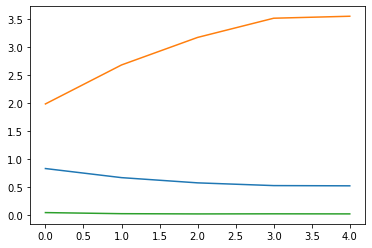

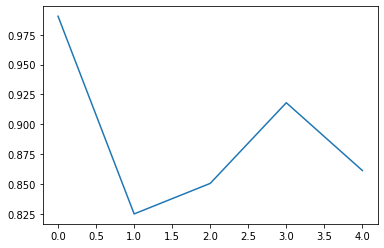

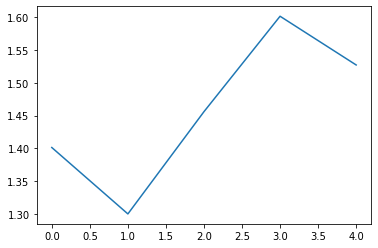

In [30]:
cudnn.benchmark = True
global args
print(args)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if not os.path.exists(args.model_g_path):
    os.makedirs(args.model_g_path)
if not os.path.exists(args.model_d_path):
    os.makedirs(args.model_d_path)
if not os.path.exists(args.model_c_path):
    os.makedirs(args.model_c_path)
if not os.path.exists(args.sample_path):
    os.makedirs(args.sample_path)
# Networks====================================================
generator = Generator(args.db, args.z_dim, args.cc_dim, args.dc_dim)
discriminator = Discriminator(args.db, args.featu_dim)
classifier = Classifier(args.db, args.cc_dim, args.dc_dim)
# Optimizers
g_optimizer = optim.Adam(generator.parameters(), args.lrG, [args.beta1, args.beta2])
d_optimizer = optim.Adam(discriminator.parameters(), args.lrD, [args.beta1, args.beta2])
c_optimizer = optim.Adam(classifier.parameters(), args.lrD, [args.beta1, args.beta2])

if torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()
    classifier.cuda()

mse_loss = 0

total_step = len(data_loader)
loss_val_d = [] 
loss_val_g = []
loss_val_c = []
loss_val_kl = []
loss_val_kl_2 = []
for epoch in range(args.num_epochs):
    epoch_loss_d = []
    epoch_loss_g = []
    epoch_loss_c = []
    epoch_kl = []
    epoch_kl_2 = []
    for i, images in enumerate(data_loader):
        # ===================== Make some images =====================#
        images = to_variable(images)
        batch_size = images.size(0) # batch size =16
        noise = to_variable(torch.randn(batch_size, args.z_dim))# noise for training
        cc = to_variable(gen_cc(batch_size, args.cc_dim))
        dc = to_variable(gen_dc(batch_size, args.dc_dim))
        fake_images = generator(torch.cat((cc, dc, noise),1))
        images = images.float().to(device)#
        # ========MSE loss=================
        MSEloss = nn.MSELoss()
        if batch_size == 8:
            mseloss1 = MSEloss( fake_images[0,:,:,:], fake_images[1,:,:,:] )
            mseloss2 = MSEloss( fake_images[1,:,:,:], fake_images[2,:,:,:] )
            mseloss3 = MSEloss( fake_images[2,:,:,:], fake_images[3,:,:,:] )
            mseloss4 = MSEloss( fake_images[3,:,:,:], fake_images[4,:,:,:] )
            mseloss5 = MSEloss( fake_images[4,:,:,:], fake_images[5,:,:,:] )
            mseloss6 = MSEloss( fake_images[5,:,:,:], fake_images[6,:,:,:] )
            mseloss7 = MSEloss( fake_images[6,:,:,:], fake_images[7,:,:,:] )
            mse_loss = mseloss1+mseloss2+mseloss3+mseloss4+mseloss5+mseloss6+mseloss7
        
        # ===================== Train D =====================#
        d_output_real, real_featu = discriminator(images)
        d_output_fake, fake_featu = discriminator(fake_images)
        d_loss_a = -torch.mean(torch.log(d_output_real[:,0]) + torch.log(1 - d_output_fake[:,0]))
        
        #===== measure KL div of fake_feature and noise ======#
        fake_featu = F.log_softmax(fake_featu)
        sof_noice = F.softmax(noise)
        feature_loss = nn.KLDivLoss()(fake_featu, sof_noice)
        epoch_kl.append(feature_loss.item())
        real_featu = F.softmax(real_featu)
        feature_loss_2 = nn.KLDivLoss()(fake_featu, real_featu)
        epoch_kl_2.append(feature_loss_2.item())
        # Optimization
        d_loss = d_loss_a #+ feature_loss
        discriminator.zero_grad()
        d_loss.backward(retain_graph=True)
        d_optimizer.step()
        epoch_loss_d.append(d_loss.item())
        
        # ===================== Train C =====================#
        c_output_real = classifier(images)
        c_output_fake = classifier(fake_images)
        # compute Entropy Loss
        output_cc = c_output_fake[:, 0:args.cc_dim]
        c_loss_cc = torch.mean((((output_cc - 0.0) / 0.5) ** 2))
        
        output_dc = c_output_fake[:, args.cc_dim:]
        output_dcR = c_output_real[:, args.cc_dim:]
        output_dcR0 = torch.argmax(output_dcR, dim=1)
        ppp_mean = torch.mean(output_dc, dim=0, keepdim=True)
        ppp_mean_R = torch.mean(output_dcR, dim=0, keepdim=True)
        entropy_marginal = get_entropy_1D(ppp_mean)
        entropy_marginal_R = get_entropy_1D(ppp_mean_R)
        entropy_mean = torch.mean(get_entropy_2D(output_dc))
        entropy_mean_R = torch.mean(get_entropy_2D(output_dcR))
        c_loss_entpy = -0.1*entropy_marginal_R +  0.03*entropy_mean_R
            
        # cross entropy loss of dc and out_dc========================
        loss = nn.CrossEntropyLoss()
        dc_0 = torch.argmax(dc, dim=1)
        output_dc0 = torch.argmax(output_dc, dim=1)
        c_loss_d = loss(output_dc, dc_0) #- 0.1*entropy_marginal
        
        c_loss_dc = c_loss_d

        c_loss = args.continuous_weight*c_loss_cc + 1.0 * c_loss_dc #- 0.1* mse_loss
        
        # Optimization
        classifier.zero_grad()
        c_loss.backward(retain_graph=True)
        c_optimizer.step()
        epoch_loss_c.append(c_loss.item())
        
        # ===================== Train G =====================#
        fake_images = generator(torch.cat((cc, dc, noise),1))
        # ========MSE loss=================
        MSEloss = nn.MSELoss()
        if batch_size == 8:
            mseloss1 = MSEloss( fake_images[0,:,:,:], fake_images[1,:,:,:] )
            mseloss2 = MSEloss( fake_images[1,:,:,:], fake_images[2,:,:,:] )
            mseloss3 = MSEloss( fake_images[2,:,:,:], fake_images[3,:,:,:] )
            mseloss4 = MSEloss( fake_images[3,:,:,:], fake_images[4,:,:,:] )
            mseloss5 = MSEloss( fake_images[4,:,:,:], fake_images[5,:,:,:] )
            mseloss6 = MSEloss( fake_images[5,:,:,:], fake_images[6,:,:,:] )
            mseloss7 = MSEloss( fake_images[6,:,:,:], fake_images[7,:,:,:] )
            mse_loss = mseloss1+mseloss2+mseloss3+mseloss4+mseloss5+mseloss6+mseloss7
            
        d_output_fake, fake_featu = discriminator(fake_images)
        c_output_fake = classifier(fake_images)
        g_loss_a = -torch.mean(torch.log(d_output_fake[:,0])) # the quality score of fake image
        
        # Re-compute Entropy Loss
        c_output_real = classifier(images)
        c_output_fake = classifier(fake_images)
        
        output_cc = c_output_fake[:, 0:args.cc_dim]
        c_loss_cc = torch.mean((((output_cc - 0.0) / 0.5) ** 2))
        
        output_dc = c_output_fake[:, args.cc_dim:]
        output_dcR = c_output_real[:, args.cc_dim:]
        
        ppp_mean = torch.mean(output_dc, dim=0, keepdim=True)
        ppp_mean_R = torch.mean(output_dcR, dim=0, keepdim=True)
        
        entropy_marginal = get_entropy_1D(ppp_mean)
        entropy_marginal_R = get_entropy_1D(ppp_mean_R)
        
        entropy_mean = torch.mean(get_entropy_2D(output_dc))
        entropy_mean_R = torch.mean(get_entropy_2D(output_dcR))
        
        c_loss_entpy = -0.1*entropy_marginal_R +  0.03*entropy_mean_R
        dc_0 = torch.argmax(dc, dim=1)
        c_loss_d = loss(output_dc, dc_0) #- 0.1*entropy_marginal
        c_loss_dc = c_loss_d

        g_loss = g_loss_a + args.continuous_weight*c_loss_cc + 1.0*c_loss_dc #- 0.1*mse_loss
        # Optimization
        generator.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        epoch_loss_g.append(g_loss.item())
        
        #========== print log ==============
        if (i + 1) % args.log_step == 0:
            print(print("output_dc0",output_dc0, "dc_0", dc_0))
            print("output_dcR0",output_dcR0, "mse",mse_loss)
            #print("output_dc",output_dc)
            print('Epoch[%d/%d],Step[%d/%d], d_loss: %.4f, c_loss: %.4f, g_loss: %.4f, g_loss_a: %.4f, KL_F&N: %.4f, KL_F&R: %.4f, entropy_marginal: %.4f, entropy_mean: %.4f'
                  % (epoch + 1, args.num_epochs, i + 1, total_step, d_loss.data, c_loss.data, g_loss.data, g_loss_a.data, 
                     feature_loss.data, feature_loss_2.data, entropy_marginal.data, entropy_mean.data)) 
        if (i + 1) % args.sample_step == 0:
            #====== cc for test ==========
            tmp = np.zeros((args.sample_size, args.cc_dim))
            for k in range(3): # cycle 16行就要循环16次，和下面的16一样
                #tmp[k * 10:(k + 1) * 10, 0] = np.linspace(0, 0, 10)
                tmp[k * 10:(k + 1) * 10, 0] = np.linspace(-2, 2, 10)
                
            cc = to_variable(torch.Tensor(tmp))
            #print(cc.shape)
            #====== dc for test ==========
            tmp = np.zeros((args.sample_size, args.dc_dim))
            for k in range(3): # cycle 修改这里是行数（类数）
                tmp[k * 10:(k + 1) * 10, k] = 1
            dc = to_variable(torch.Tensor(tmp))
            rands = torch.rand
            fixed_noise = to_variable(torch.ones(args.sample_size, args.z_dim))
            a = torch.cat((cc, dc, fixed_noise), 1)
            fake_images = generator(a)
            torchvision.utils.save_image(fake_images.data,
                                    os.path.join(args.sample_path, #args.sample_path
                                        'generated-%d-%d.png' % (epoch + 1, i + 1)), nrow=10)#列数
#             torchvision.utils.save_image(fake_images.data,os.path.join('F:/Jupyter Notebook/Deep8/results/result single imgs',
#                                                                        'generated-%d-%d.png' % (epoch + 1, i + 1)))
     
    loss_val_d.append(sum(epoch_loss_d)/len(epoch_loss_d))
    loss_val_g.append(sum(epoch_loss_g)/len(epoch_loss_g))
    loss_val_c.append(sum(epoch_loss_c)/len(epoch_loss_c))
    loss_val_kl.append(sum(epoch_kl)/len(epoch_kl))
    loss_val_kl_2.append(sum(epoch_kl_2)/len(epoch_kl_2))

    # save the model parameters for each epoch
    g_path = os.path.join(args.model_g_path, 'generator-%d.pkl' % (epoch + 1))
    d_path = os.path.join(args.model_d_path, 'discriminator-%d.pkl' % (epoch + 1))
    c_path = os.path.join(args.model_c_path, 'classifier-%d.pkl' % (epoch + 1))
    torch.save(generator.state_dict(), g_path)
    torch.save(discriminator.state_dict(), d_path)
    torch.save(classifier.state_dict(), c_path)
# plot loss curves   
plt.plot(loss_val_d) # blue
plt.plot(loss_val_g) # orange
plt.plot(loss_val_c) # green
plt.show()
plt.plot(loss_val_kl) # fake & noise (in Adam)
plt.show()
plt.plot(loss_val_kl_2) # fake & real
plt.show()

In [23]:
PATH_G = "./models/models_g_128/generator-27.pkl"
generator.load_state_dict(torch.load(PATH_G), strict=False)
generator.eval()

tmp = np.zeros((args.sample_size, args.cc_dim))
for k in range(10): # cycle 16行就要循环16次，和下面的16一样
    tmp[k * 10:(k + 1) * 10, 0] = np.linspace(-2, 2, 10)
    tmp[k * 10:(k + 1) * 10, 1] = np.linspace(0, 0, 10)
cc2 = to_variable(torch.Tensor(tmp))
tmp = np.zeros((args.sample_size, args.dc_dim))
for k in range(10): # cycle 修改这里是行数（类数）
    tmp[k * 10:(k + 1) * 10, k] = 1
dc = to_variable(torch.Tensor(tmp))
print(cc2.shape)
print(dc.shape)
print(fixed_noise.shape)

a2 = torch.cat((cc2, dc, fixed_noise), 1)
fake_images = generator(a2)

torchvision.utils.save_image(fake_images.data,
                        os.path.join(args.sample_path_2, #args.sample_path
                            'generated-%d-%d.png' % (epoch + 1, i + 1)), nrow=10)#列数

torch.Size([100, 2])
torch.Size([100, 10])
torch.Size([100, 16])


In [80]:
# ============= Load Trained D and C =================
PATH_D = "./models/models_d_128/discriminator-5.pkl"
discriminator = Discriminator(args.db, args.featu_dim)
discriminator.load_state_dict(torch.load(PATH_D), strict=False)
discriminator.eval()


Discriminator(
  (conv): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
    (3): Conv2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1, inplace=True)
    (6): Conv2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.1, inplace=True)
    (9): Conv2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (fc): Sequential(
    (0): Linear(in_features=1024, out_features=4, bias=True)
  )
  

In [81]:
PATH_C = "./models/models_c_128/classifier-5.pkl"
classifier = Classifier(args.db,args.cc_dim, args.dc_dim)
classifier.load_state_dict(torch.load(PATH_C), strict=False)
classifier.eval()


Classifier(
  (conv): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
    (3): Conv2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1, inplace=True)
    (6): Conv2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.1, inplace=True)
    (9): Conv2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (fc): Sequential(
    (0): Linear(in_features=1024, out_features=4, bias=True)
    (1): 

In [83]:
from PIL import Image
import PIL
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
PIL.Image.MAX_IMAGE_PIXELS = 320000000

from torchvision.transforms import ToTensor
transform = transforms.Compose([
    transforms.Scale((args.image_size, args.image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5,), (0.5, 0.5, 0.5, ))])
if torch.cuda.is_available():
    #generator.cuda()
    #discriminator.cuda()
    classifier.cuda()

images = Image.open('D:/KPC-F838-3_2016_07_12_024/024x8_3.tif')
#images = Image.open('F:/Jupyter Notebook/Deep8/HE/KPCL159-2-0082-HE.tif')

height = 128
width = 128
imgwidth, imgheight = images.size

rows = np.random.rand(1, 7)

for i in range(imgheight//height): #整除
    for j in range(imgwidth//width): #整除
        box = (j*width, i*height, (j+1)*width, (i+1)*height)
        #print(box)
        image_patch = images.crop(box)
        
        images_tsr = transform(image_patch)
        images_tsr = torch.unsqueeze(images_tsr, 0)
        images_tsr = images_tsr.cuda()
        
        c_output_real = classifier(images_tsr)
        output_dc = c_output_real[:, args.cc_dim : args.cc_dim+args.dc_dim]
        #print(label)
        
        label = output_dc.cpu().data
        one_row = np.append(label, box)
        one_row = np.expand_dims(one_row, axis=0)
        
        rows = np.append(rows, one_row, axis=0)
    print("current row",i,"is finished")
print(rows.shape)
rows = np.delete(rows, 0, 0)
print(rows.shape)

current row 0 is finished
current row 1 is finished
current row 2 is finished
current row 3 is finished
current row 4 is finished
current row 5 is finished
current row 6 is finished
current row 7 is finished
current row 8 is finished
current row 9 is finished
current row 10 is finished
current row 11 is finished
current row 12 is finished
current row 13 is finished
current row 14 is finished
current row 15 is finished
current row 16 is finished
current row 17 is finished
current row 18 is finished
current row 19 is finished
current row 20 is finished
current row 21 is finished
current row 22 is finished
current row 23 is finished
current row 24 is finished
current row 25 is finished
current row 26 is finished
current row 27 is finished
current row 28 is finished
current row 29 is finished
current row 30 is finished
current row 31 is finished
current row 32 is finished
current row 33 is finished
current row 34 is finished
current row 35 is finished
current row 36 is finished
current row

In [85]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
transform = transforms.Compose([
    transforms.Scale((args.image_size, args.image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5,), (0.5, 0.5, 0.5, ))])

dataset=np.load("./kpc/data1/128.npy")
print(dataset.shape)
dataset = np.moveaxis(dataset, 3, 1)
print(dataset.shape)
data_loader = data.DataLoader(dataset=dataset,
                                batch_size=1,
                                shuffle=False,
                                num_workers=args.num_workers)

(16827, 128, 128, 3)
(16827, 3, 128, 128)


In [34]:
if args.db=='kpc128': # kpc64
    #dataset = ImageFolder(args.image_path, transform)# modify the path
    dataset = np.load("./kpc/data0/slice128_Block2_11K.npy")
    print(dataset.shape)####################
    dataset = dataset[:, 0, :, :, :]
    dataset = np.moveaxis(dataset, 3, 1)
    print(dataset.shape)
    dataset.astype(float)
    dataset = dataset/255
    dataset = torch.from_numpy(dataset)
    #dataset = dataset.to(device)
    print(dataset.shape)
    
data_loader = data.DataLoader(dataset=dataset,
                                batch_size=1,
                                shuffle=False,
                                num_workers=args.num_workers)

(11000, 8, 128, 128, 3)
(11000, 3, 128, 128)
torch.Size([11000, 3, 128, 128])


In [86]:
rows = np.random.rand(1, args.featu_dim+1)

for epoch in range(args.test_epochs):
    for i, images in enumerate(data_loader):
        images = to_variable(images)        
        if torch.cuda.is_available():
            discriminator.cuda()
            classifier.cuda()
        images = images.float()
        images = images.to(device)
        
        d_output_real, real_featu = discriminator(images)
        c_output_real = classifier(images)
        #print(d_output_real.shape)
        
        real_fake = d_output_real[:,0]
        output_dc = c_output_real[:, args.cc_dim:]
        featu = real_featu.cpu().data.numpy()
        #print('featu.shape=',featu.shape)
        
        label = torch.argmax(output_dc, dim=1)
        label = label.cpu().data.numpy()
        #print('label.shape=',label.shape)
        
        one_row = np.append(featu, label)
        one_row = np.expand_dims(one_row, axis=0)
        #print(one_row,one_row.shape)
        
        rows = np.append(rows, one_row, axis=0)
    print(rows.shape)
    
    rows = np.delete(rows, 0, 0)
    print(rows.shape)

(16828, 5)
(16827, 5)


In [87]:
import pandas as pd
pd.DataFrame(rows).to_csv("./csv/label and feature 21-4.csv")